# Prova de Conceito - Reconhecimento de Faces

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

os.chdir("/home/gbrlmoraes/git_reps/fiap_pbls_2024_2/PBL_fase_6")

# Funções utilizadas

## Função para encontrar o rosto na imagem e retornar as landmarks

In [2]:
def detecta_rosto(caminho_imagem, score_threshold=0.7):

    # Convertendo a imagem para escala de cinza
    img = cv2.imread(caminho_imagem)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_cinza = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Inicializa FaceDetectorYN com parâmetros
    nms_threshold = 0.3
    yunet_shape = (img_cinza.shape[1], img_cinza.shape[0])
    topk = 50000

    # Inicializa o detector de rosto
    detector = cv2.FaceDetectorYN.create(
        "modelos/face_detection_yunet_2023mar.onnx",
        "",
        yunet_shape,
        score_threshold,
        nms_threshold,
        topk,
    )

    # Configurando o tamanho de entrada do detector de rosto
    detector.setInputSize((img_cinza.shape[1], img_cinza.shape[0]))

    # Detectando rostos na imagem
    success, faces_and_landmarks = detector.detect(img_rgb)

    if not success:
        print("Nenhum rosto detectado.")
        return None

    return faces_and_landmarks

## Função para extrair as caracteristicas do rosto detectado

In [3]:
def extrai_rosto(recognizer, caminho_imagem, score_threshold=0.7):

    # Lendo imagem e mudando as cores
    img = cv2.imread(caminho_imagem)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Extrai o array de rosto
    rosto_alinhado = recognizer.alignCrop(
        img_rgb, detecta_rosto(caminho_imagem, score_threshold)
    )
    facial_features = recognizer.feature(rosto_alinhado)

    return facial_features

## Função para classificar uma imagem

In [4]:
def classifica_rosto(caminho_img_busca, score_threshold=0.5):

    # Define o modelo de reconhecimento
    recognizer = cv2.FaceRecognizerSF.create(
        "modelos/face_recognition_sface_2021dec_int8.onnx", ""
    )

    # Processa a imagem de busca
    busca = extrai_rosto(
        recognizer, caminho_imagem=caminho_img_busca, score_threshold=score_threshold
    )

    # Variáveis iniciais
    pontuacao_max = 0
    pessoa_detectada = ""

    print("Comparando imagem com a base de treino...")
    # Compara a imagem de busca com a base de treino
    for pessoa in tqdm(os.listdir("dados/imagens_treino")):
        pontuacoes = []
        for imagem in os.listdir(
            os.path.join(os.getcwd(), "dados", "imagens_treino", pessoa)
        ):

            # Filtra outros tipos de arquivo
            if imagem.endswith(("png", "jpeg")):
                rosto = extrai_rosto(
                    recognizer,
                    caminho_imagem=os.path.join(
                        os.getcwd(), "dados", "imagens_treino", pessoa, imagem
                    ),
                    score_threshold=score_threshold,
                )
                pontuacao = recognizer.match(
                    busca, rosto, cv2.FACE_RECOGNIZER_SF_FR_COSINE
                )
                pontuacoes.append(pontuacao)

        # Guarda calcula a média de proximidade com cada pessoa da base de treino
        pontuacao_media = np.mean(pontuacoes)
        if pontuacao_media > pontuacao_max:
            pontuacao_max = pontuacao_media
            pessoa_detectada = pessoa

    # Mostra os resultados finais
    print("=" * 50)
    print(f"Pessoa detectada: {pessoa_detectada}, Pontuação: {pontuacao_max:.2f}")

    bbox = detecta_rosto(caminho_img_busca, score_threshold=score_threshold)[0].astype(
        int
    )
    plt.imshow(
        cv2.rectangle(
            cv2.cvtColor(cv2.imread(caminho_img_busca), cv2.COLOR_RGB2BGR),
            (bbox[0], bbox[1]),
            (bbox[0] + bbox[2], bbox[1] + bbox[3]),
            (0, 0, 255),
            2,
        )
    )

# Classificando imagens de teste

Comparando imagem com a base de treino...


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Pessoa detectada: Gabriel, Pontuação: 0.64


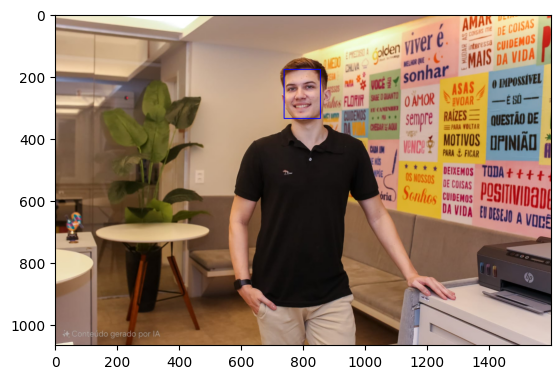

In [5]:
diretorio_teste = os.path.join(os.getcwd(), "dados", "imagens_teste")

classifica_rosto(os.path.join(diretorio_teste, "gabriel_teste.jpeg"))

Comparando imagem com a base de treino...


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Pessoa detectada: Nic, Pontuação: 0.72


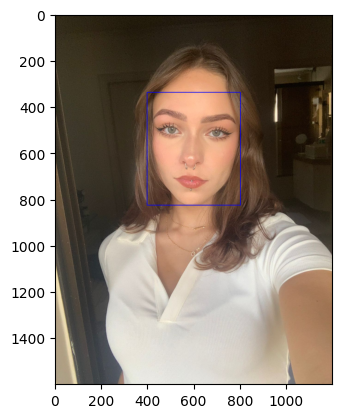

In [6]:
classifica_rosto(os.path.join(diretorio_teste, "nic_teste.jpeg"))

Comparando imagem com a base de treino...


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

Pessoa detectada: Vampeta, Pontuação: 0.53


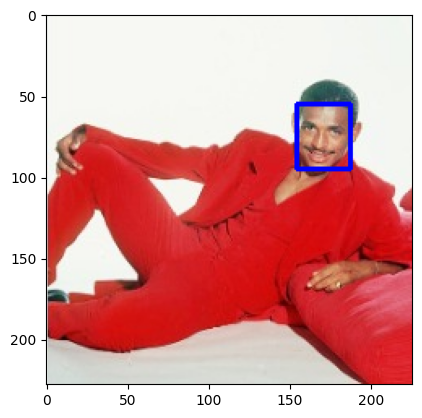

In [7]:
classifica_rosto(os.path.join(diretorio_teste, "vampeta_teste.jpeg"))

Comparando imagem com a base de treino...


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Pessoa detectada: Yan, Pontuação: 0.76


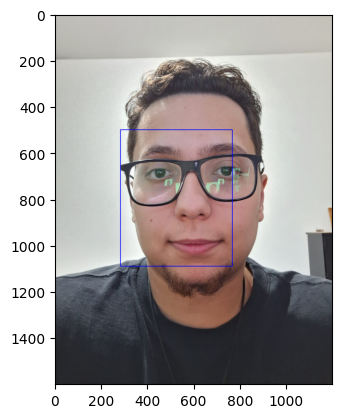

In [8]:
classifica_rosto(os.path.join(diretorio_teste, "yan_teste.jpeg"))

Comparando imagem com a base de treino...


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Pessoa detectada: Jess, Pontuação: 0.42


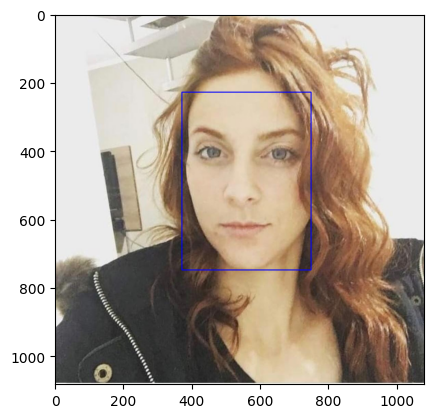

In [9]:
classifica_rosto(os.path.join(diretorio_teste, "jess_teste.jpeg"))

# Consideraçõea finais

## Breve explicação do fluxo da função:

1. detecta_rosto: Utiliza o modelo YuNet para detectar rostos em uma imagem.
2. extrai_rosto: Com base no rosto detectado, o modelo SFace é usado para alinhar e extrair as características faciais.
3. Loop de comparação:
    - Para cada pessoa no diretório de treino, ele itera pelas imagens dessa pessoa.
    - Em cada imagem, ele extrai as características faciais usando o extrai_rosto.
    - A função match compara a face da imagem de busca com as faces das imagens de treino, utilizando o método de similaridade cosseno.
    - A média das pontuações para cada pessoa é calculada.
    - A pessoa com a maior média de pontuações é considerada a pessoa detectada.

## Análise dos resultados

Com os algorítmos escolhidos foi possível contruir uma lógica para a detecção dos rostos dos integrantes do grupo, existem caminhos de melhorias como: processar melhor as imagens e melhorar a eficiência do script, mas ainda assim foi possível detectar todos corretamente utilizando uma base de dados pequena